In [972]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [973]:
matplotlib.rcParams.update({'font.size': 14})

In [974]:

def create_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    r2 = r2_score(y_test, y_pred) 
    print(f'r2 = {r2}')

**Описание датасета**

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [975]:
TRAIN_DATASET_PATH = 'train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'test.csv'
test_set = pd.read_csv(TEST_DATASET_PATH, sep=",")
train_set = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
train_set.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [976]:
print(f'train: {train_set.shape}, test: {test_set.shape}')



train: (10000, 20), test: (5000, 19)


In [977]:
train_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

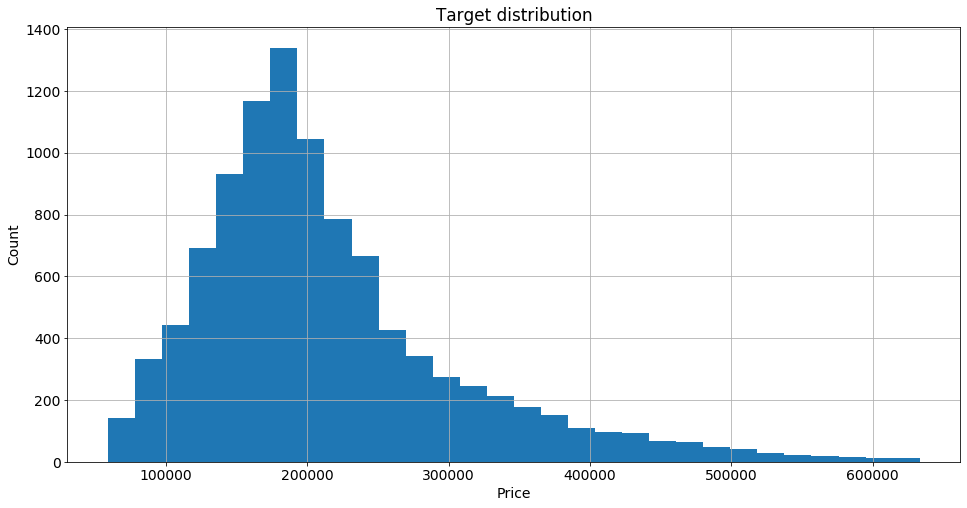

In [1067]:
plt.figure(figsize = (16, 8))

train_set['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## Анализ категориальных переменных

In [978]:
train_set_obj_features = train_set.select_dtypes(include='object')
train_set_obj_features.tail()

,Ecology_2,Ecology_3,Shops_2
9995,B,B,B
9996,B,B,A
9997,B,B,A
9998,B,A,B
9999,B,B,B


In [979]:
train_set['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [980]:
train_set['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [981]:
train_set['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# Обработка пропусков

In [982]:
train_set.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [983]:
train_set['Square'].median()

52.51330992401352

In [984]:
train_set['LifeSquare'].median()

32.781260192155735

заполнение Life square:расчет коэффициента зависимости жилой площади от общей и заполнение пропусков жилой площади с использованием этого коэффициента

In [985]:
square_diff_coef = train_set['LifeSquare'].median() / train_set['Square'].median() 
square_diff_coef

0.6242466955442353

In [986]:
train_set.loc[train_set['LifeSquare'].isnull(), 'LifeSquare'] = train_set.loc[train_set['LifeSquare'].isnull(), 'Square'] * square_diff_coef


In [987]:
train_set.isnull().sum()


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [988]:
train_set['LifeSquare'].median()

33.29048969492479

Заполнение Healthcare_1 медианой

In [989]:
train_set['Healthcare_1'].median()

900.0

In [990]:
train_set.loc[train_set['Healthcare_1'].isnull(), 'Healthcare_1'] = train_set['Healthcare_1'].median()

In [991]:
train_set.isnull().sum()


Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

все пропуски обработаны

# Обработка выбросов

In [992]:
train_set.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.300075,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.868952,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,24.352570,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,33.290490,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,44.933550,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


обработка выбросов: количество комнат

In [993]:
train_set.loc[train_set['Rooms'] >= 19, 'Rooms'] = 1

замена 19 комнат на 1 (маленькая площадь), а также 5 комнат

In [994]:
train_set.loc[train_set['Rooms'] >= 6 , 'Rooms'] = 2

In [995]:
train_set.loc[(train_set["Rooms"]>= 5) & (train_set["Square"] < 50),"Rooms"] = 1

In [996]:
train_set[train_set["Rooms"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,26.087820,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,30.889912,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,50.870766,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [997]:
train_set.loc[(train_set["Rooms"]< 1) & (train_set["Square"] < 50),"Rooms"] = 1

In [998]:
train_set.loc[(train_set["Rooms"]< 1) & (train_set["Square"] < 100),"Rooms"] = 2

In [999]:
train_set.loc[(train_set["Rooms"]< 1) & (train_set["Square"] < 150),"Rooms"] = 3

In [1000]:
train_set.loc[(train_set["Rooms"]< 1) & (train_set["Square"] < 250),"Rooms"] = 4

In [1001]:
train_set[train_set["Rooms"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


обработка выбросов: нулевая площадь кухни

In [1002]:
train_set[train_set["KitchenSquare"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74,2.0,80.312926,50.135078,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
23,6641,54,3.0,118.907612,74.227684,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.867936
39,9371,23,2.0,60.503248,37.768953,0.0,16,0.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,229778.057902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,8438,1,2.0,66.736039,41.659752,0.0,16,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,199237.847364
9953,5365,1,2.0,61.049491,38.109943,0.0,11,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,190085.168584
9960,9307,1,2.0,57.376642,35.817179,0.0,8,25.0,2016,0.007122,B,B,1,264,0,900.0,0,1,B,104450.496477
9965,6612,27,2.0,59.460685,37.118136,0.0,15,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,135784.320930


Расчет коэффициента отношения площади кухни к нежилой площади (разница между общей жилой)

In [1003]:
kitchen_coeff = train_set['KitchenSquare'].median() / (train_set['Square'].median() - train_set['LifeSquare'].median())
kitchen_coeff

0.3121290179325801

In [1004]:
train_set.loc[train_set['KitchenSquare'] < 1, 'KitchenSquare'] = kitchen_coeff * (train_set.loc[train_set['KitchenSquare'] < 1, 'Square'] - train_set.loc[train_set['KitchenSquare'] < 1, 'LifeSquare'])


In [1005]:
train_set[train_set["KitchenSquare"] < 1]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
42,9833,1,2.0,56.494318,54.723569,0.552702,9,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,196078.907289
44,10521,38,3.0,104.211396,106.340403,-0.664525,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,-1.193753,17,22.0,2016,0.007122,B,B,1,264,0,900.0,0,1,B,199215.452229
71,2136,74,2.0,84.687732,81.905552,0.868399,12,17.0,2017,0.075779,B,B,6,1437,3,900.0,0,2,B,243479.876105
72,14675,74,1.0,52.457589,52.423345,0.010689,18,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,160292.163702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,5367,1,3.0,81.227389,81.655818,-0.133725,14,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,218595.265514
9626,3742,1,1.0,53.258610,56.655126,-1.060151,6,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,161799.240623
9707,12302,30,1.0,46.072913,48.307844,-0.697587,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9793,5766,1,3.0,80.006748,83.793062,-1.181819,17,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,235519.716480


в тех местах, где есть несоответствие жилой и общей площади, присваиваем площади кухни медиану

In [1006]:
train_set.loc[train_set['KitchenSquare'] < 3, 'KitchenSquare'] = train_set['KitchenSquare'].median()

In [1007]:
train_set[train_set["KitchenSquare"] < 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,4.916138,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
65,11398,62,1.0,41.194188,25.715336,4.831399,6,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,114063.092041
246,790,23,1.0,41.074417,25.640569,4.817352,9,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,117742.435249
261,35,7,2.0,43.948288,28.578213,4.000000,6,5.0,1964,0.130618,B,B,39,10418,9,900.0,1,9,B,180923.169520
341,13457,6,1.0,40.326128,25.173452,4.729590,16,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,123044.213699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9632,4100,8,2.0,42.528433,30.941263,4.000000,3,9.0,1971,0.458174,B,A,26,4439,1,1130.0,1,5,B,202996.851329
9660,11320,27,1.0,41.299844,25.781291,4.843791,7,17.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,112163.693968
9696,14403,6,1.0,39.772905,24.828104,4.664706,13,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,127276.643909
9830,8556,58,1.0,42.488774,26.523477,4.983233,15,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,133135.515468


устранение несоответствия этажа квартиры и этажности дома

In [1008]:
train_set.loc[(train_set["Floor"] > train_set["HouseFloor"]),"HouseFloor"]= train_set.loc[(train_set["Floor"] > train_set["HouseFloor"]),"Floor"]

In [1009]:
train_set[(train_set["Floor"] > train_set["HouseFloor"])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


год постройки дома: обработка выбросов

In [1010]:
train_set[(train_set["HouseYear"] > 202000)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.26507,20.239714,9.0,9,12.0,20052011,0.13633,B,B,30,6141,10,262.0,3,6,B,254084.534396


In [1011]:
train_set.loc[(train_set["HouseYear"] > 202000),"HouseYear"] = 2005

In [1012]:
train_set.loc[(train_set["HouseYear"] > 4),"HouseYear"] = train_set['HouseYear'].median()

In [1013]:
train_set[(train_set["HouseYear"] < 1900)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


# Построение новых признаков

In [1014]:
train_set['Ecology_2'] = train_set['Ecology_2'].replace({'A':0, 'B':1})
train_set['Ecology_3'] = train_set['Ecology_3'].replace({'A':0, 'B':1})
train_set['Shops_2'] = train_set['Shops_2'].replace({'A':0, 'B':1})

In [1015]:
district_size = train_set['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [1016]:
train_set = train_set.merge(district_size, on='DistrictId', how='left')

In [1017]:
train_set['IsDistrictLarge'] = (train_set['DistrictSize'] > 100).astype(int)

In [1018]:
train_set.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1977.0,0.089040,...,33,7976,5,900.0,0,11,1,184966.930730,22,0
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1977.0,0.000070,...,46,10309,1,240.0,1,16,1,300009.450063,87,0
2,4765,53,2.0,44.947953,29.197612,4.916138,8,12.0,1977.0,0.049637,...,34,7759,0,229.0,1,3,1,220925.908524,174,1
3,5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977.0,0.437885,...,23,5735,3,1084.0,0,5,1,175616.227217,179,1
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1977.0,0.012339,...,35,5776,1,2078.0,2,4,1,150226.531644,97,0


Новый признак: Средняя цена в районе

In [1019]:
med_price_by_district = train_set.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

In [1020]:
train_set = train_set.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [1021]:
train_set.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1977.0,0.089040,...,7976,5,900.0,0,11,1,184966.930730,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1977.0,0.000070,...,10309,1,240.0,1,16,1,300009.450063,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,4.916138,8,12.0,1977.0,0.049637,...,7759,0,229.0,1,3,1,220925.908524,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977.0,0.437885,...,5735,3,1084.0,0,5,1,175616.227217,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1977.0,0.012339,...,5776,1,2078.0,2,4,1,150226.531644,97,0,158539.052715


**удаление Id, чтобы не путать модель**

In [1022]:
train_set.drop("Id", axis=1, inplace=True)

In [1023]:
train_set.drop("DistrictId", axis=1, inplace=True)

In [1024]:
train_set.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,2.0,47.981561,29.442751,6.000000,7,9.0,1977.0,0.089040,1,1,...,7976,5,900.0,0,11,1,184966.930730,22,0,207786.135836
1,3.0,65.683640,40.049543,8.000000,7,9.0,1977.0,0.000070,1,1,...,10309,1,240.0,1,16,1,300009.450063,87,0,300009.450063
2,2.0,44.947953,29.197612,4.916138,8,12.0,1977.0,0.049637,1,1,...,7759,0,229.0,1,3,1,220925.908524,174,1,263206.223152
3,2.0,53.352981,52.731512,9.000000,8,17.0,1977.0,0.437885,1,1,...,5735,3,1084.0,0,5,1,175616.227217,179,1,166809.665642
4,1.0,39.649192,23.776169,7.000000,11,12.0,1977.0,0.012339,1,1,...,5776,1,2078.0,2,4,1,150226.531644,97,0,158539.052715


**разделение на признаки и цену**

In [1025]:
y = pd.DataFrame(data=train_set['Price'], columns=['Price'])
X = train_set.drop('Price', axis=1)

**Разделение на train и valid**

In [1026]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Линейная регрессия

In [1027]:
model = LinearRegression()

In [1028]:
create_model(X_train, y_train, X_valid, y_valid, model)

r2 = 0.6493002884960153


# Нормализация признаков

In [1029]:
scaler = StandardScaler()

In [1030]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [1031]:
X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

In [1032]:
create_model(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2 = 0.6493002884960268


# RandomForestRegressor

In [1033]:
fr = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)

In [1034]:
create_model(X_train_scaled, y_train.values[:, 0], X_valid_scaled, y_valid, fr)

r2 = 0.7361216398642215


лучшая модель, применяем ее

# Применение к тестовому датасету

# Обработка признаков тестового датасета

In [1035]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

**Обработка пропусков**

In [1036]:
test_set.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

заполнение Life square:расчет коэффициента зависимости жилой площади от общей и заполнение пропусков жилой площади с использованием этого коэффициента

In [1037]:
test_set.loc[test_set['LifeSquare'].isnull(), 'LifeSquare'] = test_set.loc[test_set['LifeSquare'].isnull(), 'Square'] * square_diff_coef

Заполнение Healthcare_1 медианой

In [1038]:
test_set.loc[test_set['Healthcare_1'].isnull(), 'Healthcare_1'] = test_set['Healthcare_1'].median()

In [1039]:
test_set.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

пропуски обработаны

**Обработка выбросов**

In [1040]:
test_set.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.486928,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,16.771138,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,24.486238,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,33.563659,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.022851,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**обработка выбросов: количество комнат**

In [1041]:
test_set[test_set["Rooms"] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,69.135462,0.0,2,2.0,2015,0.014073,B,B,2,475,0,900.0,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,900.0,1,4,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


явная ошибка с 17 комнатами

In [1042]:
test_set.loc[test_set['Rooms'] >= 10, 'Rooms'] = 1

нулевое количество комнат

In [1043]:
test_set[test_set["Rooms"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B


In [1044]:
test_set.loc[(test_set["Rooms"]< 1) & (test_set["Square"] < 80),"Rooms"] = 2

In [1045]:
test_set.loc[(test_set["Rooms"]< 1) & (test_set["Square"] < 120),"Rooms"] = 4

**обработка выбросов: нулевая площадь кухни**

In [1046]:
test_set[test_set["KitchenSquare"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
22,12694,27,3.0,83.670032,46.358356,0.0,8,0.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
24,8968,27,2.0,69.849239,43.603157,0.0,3,0.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
30,2982,6,2.0,63.460684,39.615123,0.0,13,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
32,2449,1,1.0,66.426585,41.466576,0.0,14,0.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
43,11513,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B
4973,1804,27,1.0,38.916778,24.293670,0.0,11,17.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
4974,5296,52,1.0,44.442218,44.634608,0.0,5,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B
4976,4723,95,1.0,45.542940,28.430030,0.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B


применение "кухонного коэффициента" для расчета площади кухни

In [1047]:
test_set.loc[test_set['KitchenSquare'] < 1, 'KitchenSquare'] = kitchen_coeff * (test_set.loc[test_set['KitchenSquare'] < 1, 'Square'] - test_set.loc[test_set['KitchenSquare'] < 1, 'LifeSquare'])

In [1048]:
test_set[test_set["KitchenSquare"] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
43,11513,1,1.0,37.484057,40.593036,-0.970403,4,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
174,1481,23,1.0,31.167933,30.527056,0.200036,11,9.0,2015,0.034656,B,B,0,168,0,900.0,0,0,B
340,5017,27,2.0,57.331148,58.709650,-0.430271,4,17.0,2018,0.011654,B,B,4,915,0,900.0,0,0,B
350,4885,11,1.0,44.350481,42.958374,0.434517,2,4.0,1977,0.012339,B,B,35,5776,1,2078.0,2,4,B
358,8205,1,3.0,75.541672,76.511240,-0.302630,15,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527,12838,23,2.0,63.005569,62.313963,0.215871,18,25.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
4779,5152,23,1.0,36.330427,39.790094,-1.079863,6,4.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B
4913,13309,62,1.0,54.605305,53.427529,0.367618,12,17.0,2019,0.072158,B,B,2,629,1,900.0,0,0,A
4969,4821,74,2.0,82.542507,82.585069,-0.013285,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B


в тех местах, где есть несоответствие жилой и общей площади, присваиваем площади кухни медиану

In [1049]:
test_set.loc[test_set['KitchenSquare'] < 3, 'KitchenSquare'] = test_set['KitchenSquare'].median()

устранение несоответствия этажа квартиры и этажности дома

In [1050]:
test_set.loc[(test_set["Floor"] > test_set["HouseFloor"]),"HouseFloor"]= test_set.loc[(test_set["Floor"] > test_set["HouseFloor"]),"Floor"]

**Построение новых признаков**

In [1051]:
test_set['Ecology_2'] = test_set['Ecology_2'].replace({'A':0, 'B':1})
test_set['Ecology_3'] = test_set['Ecology_3'].replace({'A':0, 'B':1})
test_set['Shops_2'] = test_set['Shops_2'].replace({'A':0, 'B':1})

In [1052]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [1053]:
district_size = test_set['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [1054]:
test_set = test_set.merge(district_size, on='DistrictId', how='left')

In [1055]:
test_set['IsDistrictLarge'] = (test_set['DistrictSize'] > 100).astype(int)

перенос признака Средняя цена по району

In [1056]:
test_set = test_set.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [1057]:
test_set.loc[test_set['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_set['MedPriceByDistrict'].median()

удаляем DistrictID, чтобы не путать модель

In [1058]:
test_set.drop("DistrictId", axis=1, inplace=True)

In [1059]:
test_id = test_set['Id']
test_id

0         725
1       15856
2        5480
3       15664
4       14275
        ...  
4995     8180
4996     4695
4997     5783
4998     4780
4999    12504
Name: Id, Length: 5000, dtype: int64

In [1060]:
test_set.drop("Id", axis=1, inplace=True)

**Нормализация признаков**

In [1061]:
test_scaled = scaler.fit_transform(test_set)
test_scaled = pd.DataFrame(test_scaled, columns=test_set.columns)

In [1062]:
test_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               5000 non-null   float64
 1   Square              5000 non-null   float64
 2   LifeSquare          5000 non-null   float64
 3   KitchenSquare       5000 non-null   float64
 4   Floor               5000 non-null   float64
 5   HouseFloor          5000 non-null   float64
 6   HouseYear           5000 non-null   float64
 7   Ecology_1           5000 non-null   float64
 8   Ecology_2           5000 non-null   float64
 9   Ecology_3           5000 non-null   float64
 10  Social_1            5000 non-null   float64
 11  Social_2            5000 non-null   float64
 12  Social_3            5000 non-null   float64
 13  Healthcare_1        5000 non-null   float64
 14  Helthcare_2         5000 non-null   float64
 15  Shops_1             5000 non-null   float64
 16  Shops_

Применение модели RandomForestRegressor

In [1063]:
price = fr.predict(test_scaled)

In [1064]:
predictions = pd.DataFrame({ 'Id': test_id, 'Price': price })

In [1065]:
predictions.head()

,Id,Price
0,725,165254.645729
1,15856,244659.422090
2,5480,193307.951199
3,15664,321626.827569
4,14275,139678.673699


In [1066]:
predictions.to_csv("OTinyakova_predictions", index=False)